In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import plotly.express as px
import plotly.graph_objects as go
from folium import Popup

file_o3_clean = '/Users/gabrielerizzo/Programmazione/PROJECT AirQuality/df_o3_clean.csv'
df_o3_clean = pd.read_csv(file_o3_clean, sep=";")

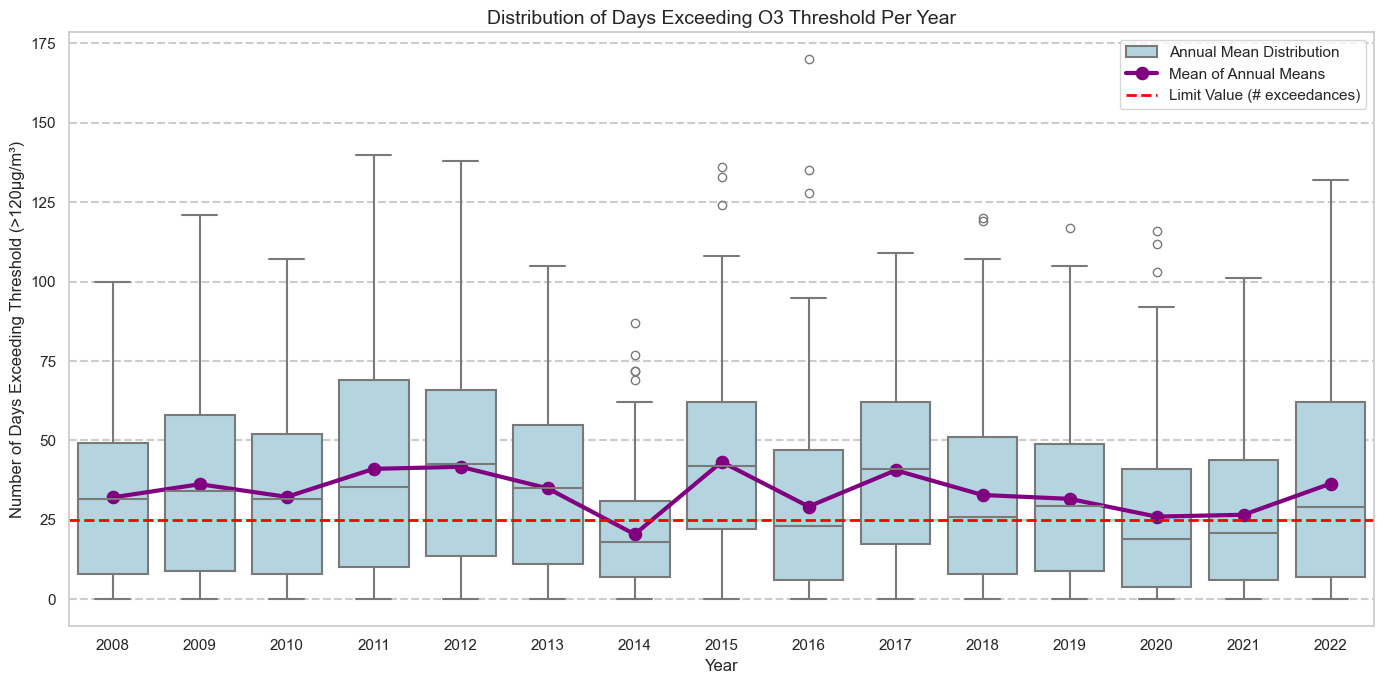

In [3]:
# Calculate yearly averages for 'giorni_mm8_over_120'
yearly_means = df_o3_clean.groupby('yy')['giorni_mm8_over_120'].mean().reset_index()

# Configure theme and figure size
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 7))

# Create a boxplot for yearly distribution
sns.boxplot(data=df_o3_clean, x='yy', y='giorni_mm8_over_120', color='lightblue', 
            showfliers=True, linewidth=1.5, boxprops=dict(alpha=1), label='Annual Mean Distribution')

# Create a pointplot for yearly averages
sns.pointplot(data=yearly_means, x='yy', y='giorni_mm8_over_120', color='purple', markers='o', 
              errorbar=None, linestyles='-', label='Mean of Annual Means', linewidth=3)

# Add reference line (hypothetical threshold of 120µg/m³)
plt.axhline(25, color='red', linestyle='--', linewidth=2, label='Limit Value (# exceedances)')

# Add labels, title, and grid
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Days Exceeding Threshold (>120µg/m³)', fontsize=12)
plt.title('Distribution of Days Exceeding O3 Threshold Per Year', fontsize=14)
plt.grid(axis='y', linestyle='--', linewidth=1.5, alpha=1)
plt.legend()
plt.tight_layout()
plt.show()


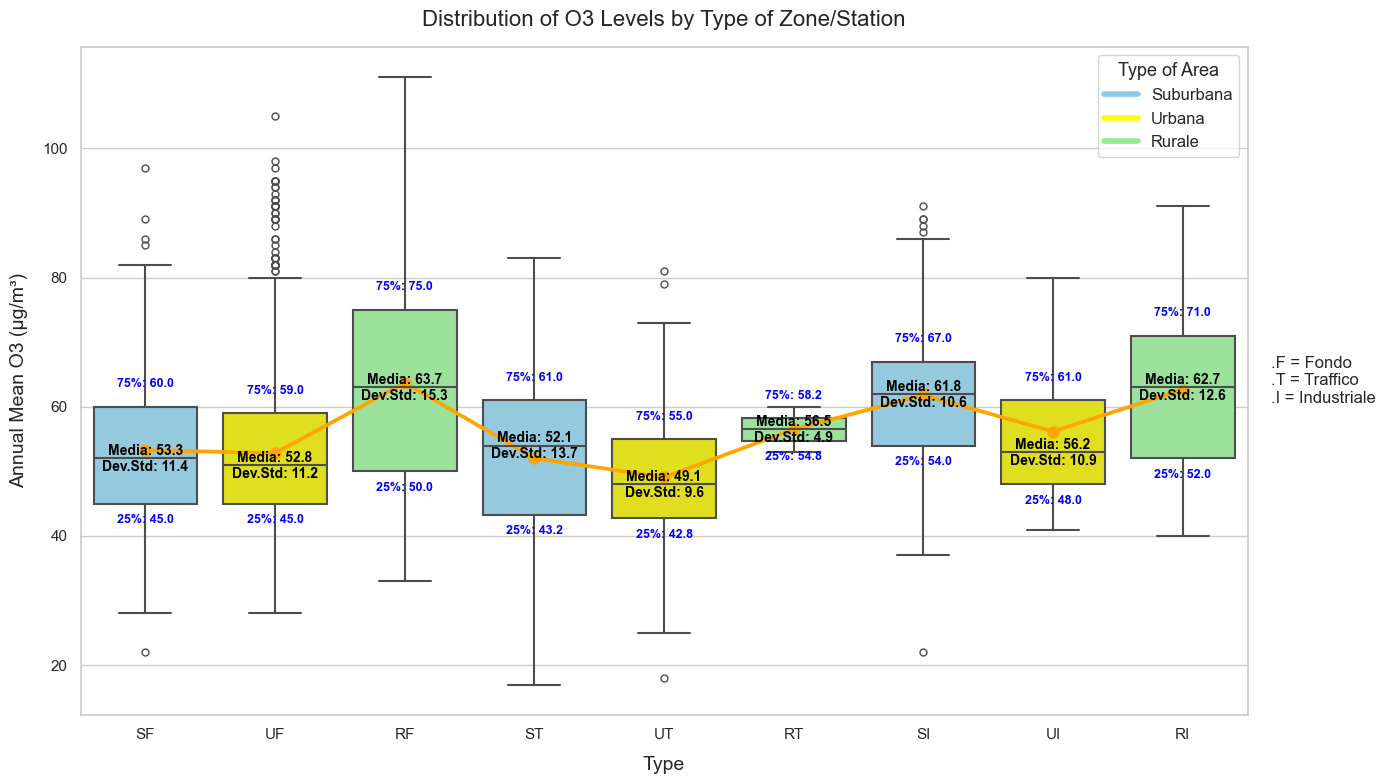

In [4]:
tipo_colors = {
    'SF': 'skyblue',
    'ST': 'skyblue',
    'SI': 'skyblue',
    'UF': 'yellow',
    'UT': 'yellow',
    'UI': 'yellow',
    'RF': 'lightgreen',
    'RT': 'lightgreen',
    'RI': 'lightgreen',
}

tipo_order = ['SF', 'UF', 'RF', 'ST', 'UT', 'RT', 'SI', 'UI', 'RI']

# Calcola la media delle medie annuali per ogni tipo di stazione
mean_of_means = df_o3_clean.groupby('TIPO')['media_yy'].mean().reset_index()

# Calcola le statistiche numeriche per ogni tipo, inclusi i percentili
statistiche = df_o3_clean.groupby('TIPO')['media_yy'].agg(
    mean='mean',
    median='median',
    std='std',
    min='min',
    max='max',
    perc25=lambda x: x.quantile(0.25),
    perc75=lambda x: x.quantile(0.75)
).reset_index()

# Imposta lo stile del grafico
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

# Crea il boxplot con l'ordine personalizzato per i tipi
sns.boxplot(data=df_o3_clean, x='TIPO', y='media_yy', order=tipo_order, hue='TIPO', palette=tipo_colors, linewidth=1.5, fliersize=5)

# Aggiungi al grafico
sns.pointplot(
    data=mean_of_means,
    x='TIPO',
    y='media_yy',
    order=tipo_order,
    color='orange',
    markers='o',
    linestyles='-',
    label='Mean of Annual Means'
)

# Titoli e etichette
plt.title('Distribution of O3 Levels by Type of Zone/Station', fontsize=16, pad=15)
plt.xlabel('Type', fontsize=14, labelpad=10)
plt.ylabel('Annual Mean O3 (µg/m³)', fontsize=14, labelpad=10)

# Aggiungi le statistiche numeriche sul grafico
for index, row in statistiche.iterrows():
    tipo = row['TIPO']
    mean = row['mean']
    median = row['median']
    std = row['std']
    perc25 = row['perc25']
    perc75 = row['perc75']
    
    # Trova la posizione sull'asse x per ogni tipo
    x_pos = tipo_order.index(tipo)

    # Aggiungi le annotazioni di media e deviazione standard sopra ogni boxplot
    plt.text(x_pos, median + 0.5, f"Media: {mean:.1f}", color='black', ha='center', fontsize=10, fontweight='bold')
    plt.text(x_pos, median - 2, f"Dev.Std: {std:.1f}", color='black', ha='center', fontsize=10, fontweight='bold')

    # Aggiungi annotazioni per i percentili
    plt.text(x_pos, perc25 - 3, f"25%: {perc25:.1f}", color='blue', ha='center', fontsize=9, fontweight='bold')
    plt.text(x_pos, perc75 + 3, f"75%: {perc75:.1f}", color='blue', ha='center', fontsize=9, fontweight='bold')

# Aggiungi la legenda personalizzata per le aree
area_labels = {
    'skyblue': 'Suburbana',
    'yellow': 'Urbana',
    'lightgreen': 'Rurale'
}
custom_legend = [plt.Line2D([0], [0], color=color, lw=4) for color in area_labels.keys()]
plt.legend(custom_legend, area_labels.values(), title='Type of Area', fontsize=12, title_fontsize=13)

# Aggiungi ulteriore legenda esplicativa per Fondo, Traffico, Industriale
extra_legend_text = """
.F = Fondo
.T = Traffico
.I = Industriale
"""
plt.text(1.02, 0.5, extra_legend_text, fontsize=12, transform=plt.gca().transAxes, verticalalignment='center')

# Mostra il grafico
plt.tight_layout()
plt.show()

In [ ]:
#media 2008-2022

# Preprocess 'Lat' and 'Lon' columns to ensure they are numeric
df_o3_clean['Lat'] = df_o3_clean['Lat'].astype(str).str.replace(',', '.').astype(float)
df_o3_clean['Lon'] = df_o3_clean['Lon'].astype(str).str.replace(',', '.').astype(float)

# Calculate the average "giorni_mm8_over_120" for each station
df_avg = df_o3_clean.groupby(['Lat', 'Lon', 'Comune', 'nome_stazione']).agg(
    media_giorni_mm8=('giorni_mm8_over_120', 'mean')
).reset_index()

# Function to define colors based on the average days exceeding the threshold
def define_color(concentration):
    if concentration > 25:
        return 'red', '(25;+]'
    elif 0 < concentration <= 25:
        return 'yellow', '(0;25]'
    elif concentration == 0:
        return 'green', '[0]'
    else:
        return "gray"

# Add columns for colors and labels for the legend
df_avg[['color', 'color_label']] = df_avg['media_giorni_mm8'].apply(lambda x: pd.Series(define_color(x)))

# Define the order and mapping of ranges for the legend
color_order = ['[0]', '(0;25]', '(25;+]']
color_discrete_map = {
    '[0]': 'green',
    '(0;25]': 'yellow',
    '(25;+]': 'red'
}

# Create the figure
fig = go.Figure()

# Add markers for each color range
for label in color_order:
    df_label = df_avg[df_avg['color_label'] == label]
    fig.add_trace(
        go.Scattermapbox(
            lat=df_label['Lat'],
            lon=df_label['Lon'],
            mode='markers',
            marker=dict(
                size=10,
                color=color_discrete_map[label],
                opacity=1
            ),
            text=df_label.apply(
                lambda row: f"Station: {row['nome_stazione']}<br>"
                            f"City: {row['Comune']}<br>"
                            f"Avg Giorni MM8 Over 120: {row['media_giorni_mm8']:.2f}", axis=1
            ),
            hoverinfo='text',
            name=label  # Use the label for the legend
        )
    )

# Configure the map layout
fig.update_layout(
    mapbox=dict(
        style="open-street-map",
        center=dict(lat=41.8719, lon=12.5674),  # Central coordinates for Italy
        zoom=5
    ),
    margin={"r": 0, "t": 30, "l": 0, "b": 0},
    title="Map of Avg Giorni MM8 Over 120 by Station",
    legend=dict(
        title="Ranges of Avg Giorni MM8 Over 120",
        itemsizing="constant"
    )
)

# Show the figure
fig.show()

# Optionally save the map as an HTML file
# fig.write_html("map_avg_giorni_mm8_over_120.html", auto_open=False)


In [5]:
# Ensure 'yy' is a string and sort the DataFrame
df_o3_clean['yy'] = df_o3_clean['yy'].astype(str)
df_o3_clean = df_o3_clean.sort_values(by='yy')

# Preprocess 'Lat' and 'Lon' columns to ensure they are numeric
df_o3_clean['Lat'] = df_o3_clean['Lat'].astype(str).str.replace(',', '.').astype(float)
df_o3_clean['Lon'] = df_o3_clean['Lon'].astype(str).str.replace(',', '.').astype(float)

# Function to define colors based on the average days exceeding the threshold
def define_color_label(concentration):
    if concentration > 25:
        return 'red', '(25;+]'
    elif 0 < concentration <= 25:
        return 'yellow', '(0;25]'
    elif concentration == 0:
        return 'green', '[0]'
    else:
        return "gray", "No Data"

# Add columns for colors and labels for the legend
df_o3_clean[['color', 'color_label']] = df_o3_clean['giorni_mm8_over_120'].apply(
    lambda x: pd.Series(define_color_label(x))
)

# Define the order and mapping of ranges for the legend
color_order = ['[0]', '(0;25]', '(25;+]']
color_discrete_map = {
    '[0]': 'green',
    '(0;25]': 'yellow',
    '(25;+]': 'red'
}

# Get the list of unique years and the initial year
years = sorted(df_o3_clean['yy'].unique())
initial_year = years[-1]
df_initial = df_o3_clean[df_o3_clean['yy'] == initial_year]

# Create the base figure
fig = go.Figure()

# Add traces for each color range
for label in color_order:
    df_label = df_initial[df_initial['color_label'] == label]
    fig.add_trace(
        go.Scattermapbox(
            lat=df_label['Lat'],
            lon=df_label['Lon'],
            mode='markers',
            marker=dict(
                size=10,
                color=color_discrete_map[label],
                opacity=1
            ),
            text=df_label.apply(
                lambda row: f"Station: {row['nome_stazione']}<br>"
                            f"City: {row['Comune']}<br>"
                            f"Year: {row['yy']}<br>"
                            f"Avg Giorni MM8 Over 120: {row['giorni_mm8_over_120']:.2f}", axis=1
            ),
            hoverinfo='text',
            name=label,
            showlegend=True
        )
    )

# Create frames for each year to enable animation
frames = [go.Frame(data=fig.data, name='initial')]
for year in years:
    frame_data = [
        go.Scattermapbox(
            lat=df_o3_clean[(df_o3_clean['yy'] == year) & (df_o3_clean['color_label'] == label)]['Lat'],
            lon=df_o3_clean[(df_o3_clean['yy'] == year) & (df_o3_clean['color_label'] == label)]['Lon'],
            mode='markers',
            marker=dict(
                size=10,
                color=color_discrete_map[label],
                opacity=1
            ),
            text=df_o3_clean[(df_o3_clean['yy'] == year) & (df_o3_clean['color_label'] == label)].apply(
                lambda row: f"Station: {row['nome_stazione']}<br>"
                            f"City: {row['Comune']}<br>"
                            f"Year: {row['yy']}<br>"
                            f"Avg Giorni MM8 Over 120: {row['giorni_mm8_over_120']:.2f}", axis=1
            ),
            hoverinfo='text',
            name=label,
            showlegend=True
        ) for label in color_order
    ]
    frames.append(go.Frame(data=frame_data, name=year))

fig.frames = frames

# Define slider steps
slider_steps = [
    dict(
        method="animate",
        args=[
            [year],
            dict(
                mode="immediate",
                frame=dict(duration=300, redraw=True),
                transition=dict(duration=0)
            )
        ],
        label=year
    ) for year in years
]

# Add the slider and animation buttons
fig.update_layout(
    mapbox=dict(
        style="open-street-map",
        center=dict(lat=41.8719, lon=12.5674),
        zoom=5
    ),
    margin={"r": 0, "t": 30, "l": 0, "b": 100},
    title="Map of Days MM8 Over 120 by Station and Year",
    updatemenus=[
        dict(
            type="buttons",
            showactive=False,
            y=0,
            x=0,
            xanchor="left",
            yanchor="bottom",
            pad=dict(t=10, l=10),
            buttons=[
                dict(
                    label="Play",
                    method="animate",
                    args=[
                        None,
                        dict(
                            frame=dict(duration=500, redraw=True),
                            transition=dict(duration=0),
                            fromcurrent=True,
                            mode='immediate'
                        )
                    ]
                ),
                dict(
                    label="Pause",
                    method="animate",
                    args=[
                        [None],
                        dict(
                            frame=dict(duration=0, redraw=False),
                            transition=dict(duration=0),
                            mode='immediate'
                        )
                    ]
                )
            ]
        )
    ],
    sliders=[
        dict(
            active=years.index(initial_year),
            currentvalue={"prefix": "Year: "},
            pad={"t": 10},
            steps=slider_steps,
            len=0.9,
            x=0.05,
            y=0,
            xanchor='left'
        )
    ],
    legend=dict(
        title="Ranges of Avg Giorni MM8 Over 120",
        itemsizing='constant'
    )
)

# Show the figure
fig.show()

# Save the figure as an HTML file without autoplay
# fig.write_html("map_giorni_mm8_over_120_definitiva.html", auto_play=False)
